# CNN on MNIST

First I'll see how jax works, then I'll get serious and use Flax or Keras3 to train a CNN on MNIST.

I'll go for the smallest model I can with the best accuracy.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from jax import grad, jit, vmap
from jax import random

plt.style.use("dark_background")
key = random.key(0)

In [ ]:
a = jnp.array([1,2,3], dtype=jnp.float32)
a

Array([1., 2., 3.], dtype=float32)

In [ ]:
b = a.clone()
b*=2
b

Array([2., 4., 6.], dtype=float32)

In [ ]:
def matmul(a,b):
	return a @ b
grad(matmul, (0,1))(a,b)

(Array([2., 4., 6.], dtype=float32), Array([1., 2., 3.], dtype=float32))

In [ ]:
t = random.normal(key, (32,32))
t

Array([[ 0.44198492,  1.4162407 ,  1.1836281 , ...,  0.76268387,
         1.6730201 , -0.7919397 ],
       [ 0.3699017 , -0.6458218 ,  0.34752584, ...,  0.37117738,
        -0.12576506,  0.15747534],
       [ 0.5894196 , -1.1405163 , -2.1414492 , ...,  0.32962143,
        -0.1306958 , -0.33589256],
       ...,
       [-0.34253454, -0.83690214,  0.2501121 , ..., -0.8274586 ,
        -0.37825716, -0.72685933],
       [-0.21192348,  1.0094156 , -1.3232409 , ...,  0.6742543 ,
         0.4670012 , -0.26775917],
       [ 2.217044  ,  0.9682738 ,  0.7508859 , ..., -0.51736134,
         0.43506762,  0.26947   ]], dtype=float32)

In [ ]:
jnp.linalg.inv(t)@t

Array([[ 1.0000000e+00, -4.3263549e-07,  3.2943905e-07, ...,
        -6.0542902e-07, -4.7928165e-07,  4.5479263e-07],
       [-5.6935903e-07,  1.0000002e+00, -1.5449623e-07, ...,
        -1.0179974e-06,  5.4067942e-07,  1.0584798e-06],
       [-4.1683845e-07,  3.9890290e-07,  1.0000001e+00, ...,
         2.8305678e-07,  6.5310269e-07,  1.7909557e-08],
       ...,
       [-3.0620704e-08, -1.6480183e-07,  1.0404414e-07, ...,
         9.9999994e-01,  4.8468581e-07,  5.3519943e-07],
       [ 1.4901161e-07, -7.4505806e-08,  9.6857548e-08, ...,
         1.7881393e-07,  9.9999988e-01, -1.2107193e-07],
       [-7.7113509e-07, -1.7881393e-07,  3.5762787e-07, ...,
        -1.4901161e-07,  2.6822090e-07,  1.0000006e+00]], dtype=float32)

Okay, seems simple enough, how do I load stuff into the GPU and JIT?

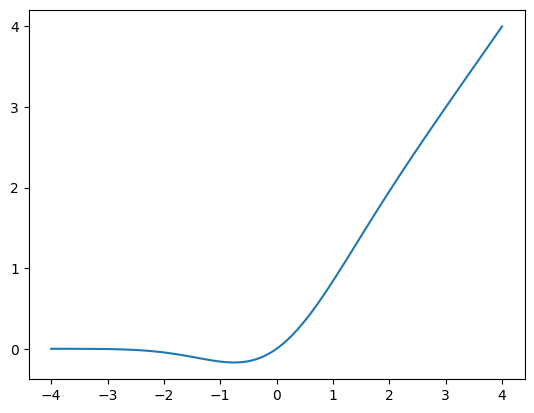

In [ ]:
def gelu(x):
	return 0.5*x*(1 + jnp.tanh(
		jnp.sqrt(2/jnp.pi)*(x + 0.044715*jnp.pow(x, 3))
	))

xs = jnp.linspace(-4,4, 100)
ys = gelu(xs)
plt.plot(xs, ys)

In [ ]:
%timeit gelu(xs).block_until_ready()

260 μs ± 49.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
gelu_jit = jit(gelu)

In [ ]:
%timeit gelu_jit(xs).block_until_ready()

9.12 μs ± 87.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


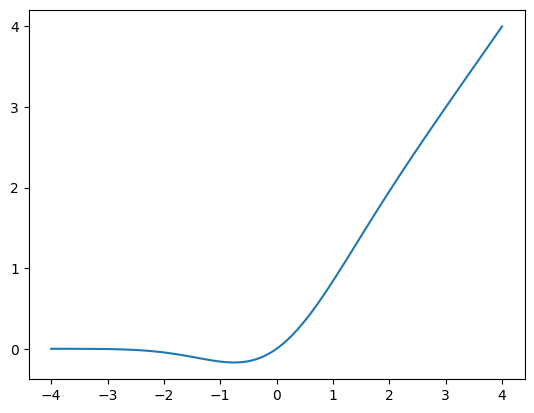

In [ ]:
plt.plot(xs, gelu_jit(xs))

JIT works real well! How about on GPU or other ways to parallelize?

In [ ]:
def mat_vec_mul(a,b):
	return a @ b

mat_vec_mul(jnp.array([[1,2], [3,4]]), jnp.array([[3], [4]]))

Array([[11],
       [25]], dtype=int32)

In [ ]:
def mat_mat_mul(a,b):
	return vmap(mat_vec_mul, (None, 1), 1)(a,b)


mat = jnp.array([[1,2], [3,4]])
print(mat@mat)
print(mat_mat_mul(mat, mat))

[[ 7 10]
 [15 22]]
[[ 7 10]
 [15 22]]


Okay I generally get the gist of it, let's see how to load objects into other devices.

In [ ]:
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

gpu


<ipython-input-2-dd3a9dbad2db>:3: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


In [ ]:
a = random.normal(key, (100, 100))
a

Array([[ 1.3969241 ,  0.25045034, -2.1396856 , ...,  0.3145455 ,
        -1.4147886 , -0.9089208 ],
       [-0.7179685 , -0.55156016,  0.5488421 , ...,  1.0389215 ,
         0.6316356 ,  1.2083954 ],
       [ 0.1089396 ,  0.41924244,  0.61395687, ..., -0.25856677,
         2.026924  , -0.840388  ],
       ...,
       [-1.7753865 ,  0.47193787, -1.0666512 , ..., -0.05554172,
         1.7904825 , -0.38509572],
       [ 1.1479    , -0.8108315 , -0.14811768, ...,  0.29534367,
         0.20607775, -0.40122998],
       [-0.8252757 ,  0.60466516,  2.5560381 , ...,  0.07566901,
         1.3775586 ,  0.7038264 ]], dtype=float32)

In [ ]:
%timeit (a@a).block_until_ready()

188 µs ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## CNN MNIST NOW!

Okay, I'm roughly familiar with how this works. Just to make myself more familliar, I'll use keras3 for the model code for the CNN. I'll use FLAX later on. First I'll load in the dataset for training.

I'll get some help form https://keras.io/guides/writing_a_custom_training_loop_in_jax/

In [2]:
import keras
import os
import jax
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# shuffle the inputs for training so I don't split them weirdly
train_shuffled = random.permutation(key, jnp.arange(x_train.shape[0]))
x_train = x_train[train_shuffled]
y_train = y_train[train_shuffled]

# split train into validation and train set
val_split = 1_000
x_val = x_train[:val_split]
y_val = y_train[:val_split]
x_train = x_train[val_split:]
y_train = y_train[val_split:]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
def onehot(x):
  return jax.nn.one_hot(x, num_classes=10, axis=-1)

y_train_onehot = onehot(y_train)
y_val_onehot = onehot(y_val)
y_test_onehot = onehot(y_test)

true label 1


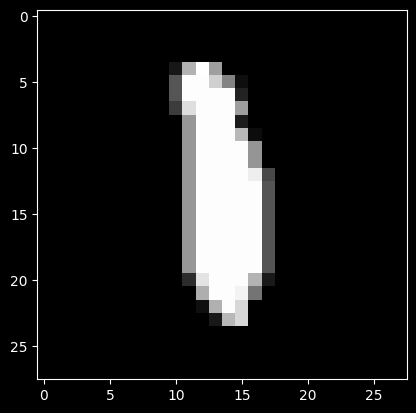

In [5]:
plt.imshow(x_train[0], cmap="gray")
print("true label", y_train[0])

Next up create a minimal model that outputs probabilites for the digits 0-9. I will iterate on this model, so no need for it to be good at all!

No special deep learning sauce to be seen yet.

In [13]:
def nn_v0():
  inputs = keras.Input(shape=(28, 28))
  flat = keras.layers.Flatten()(inputs)
  h0 = keras.layers.Dense(128, activation="relu")(flat)
  outputs = keras.layers.Dense(10)(h0)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

model = nn_v0()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [9]:
history = model.fit(x_train, y_train_onehot, epochs=20,
                    validation_data=(x_val, y_val_onehot))

Epoch 1/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8029 - loss: 5.9689 - val_accuracy: 0.8840 - val_loss: 0.4994
Epoch 2/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8973 - loss: 0.4101 - val_accuracy: 0.9100 - val_loss: 0.3506
Epoch 3/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9248 - loss: 0.2879 - val_accuracy: 0.9390 - val_loss: 0.2283
Epoch 4/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9363 - loss: 0.2400 - val_accuracy: 0.9390 - val_loss: 0.2334
Epoch 5/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9422 - loss: 0.2254 - val_accuracy: 0.9380 - val_loss: 0.2705
Epoch 6/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9463 - loss: 0.2093 - val_accuracy: 0.9450 - val_loss: 0.2124
Epoch 7/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9493 - loss: 0.1942 - val_accuracy: 0.9450 - val_loss: 0.2225
Epoch 8/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9534 - loss: 0.1871 - 

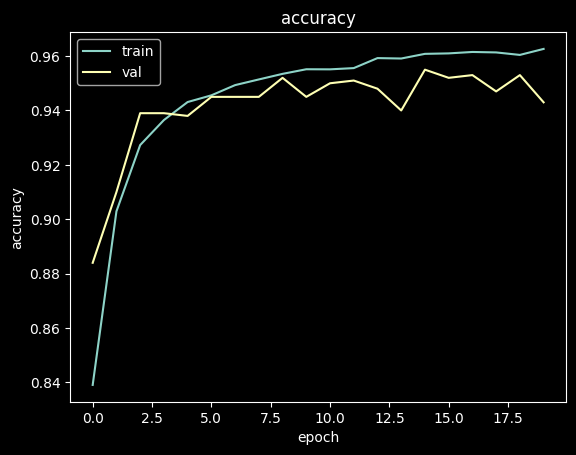

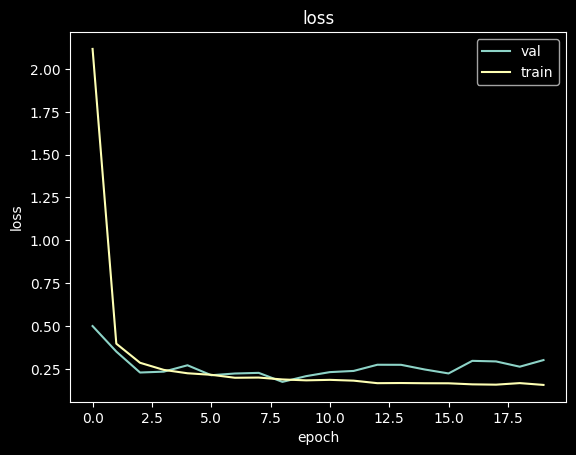

In [19]:
def plot_history(history):
  plt.plot(history.history["accuracy"], label="train")
  plt.plot(history.history["val_accuracy"], label="val")
  plt.title("accuracy")
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.show()


  plt.plot(history.history["val_loss"], label="val")
  plt.plot(history.history["loss"], label="train")
  plt.legend()
  plt.title("loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.show()

plot_history(history)

In [12]:
model.evaluate(x_test, y_test_onehot)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9437 - loss: 0.4616


[0.4034276604652405, 0.9469000101089478]

Best I can do is 94% given the model v0. I bet I could do better with a slightly larger mlp model. Let's try that first before moving onto CNN.

Let's double the hidden layer params before making the neural net deeper.

In [17]:
def nn_v1():
  inputs = keras.Input(shape=(28, 28))
  flat = keras.layers.Flatten()(inputs)

  h0 = keras.layers.Dense(256, activation="relu")(flat)

  outputs = keras.layers.Dense(10)(h0)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

model = nn_v1()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203,530 (795.04 KB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(x_train, y_train_onehot, epochs=20,
                    validation_data=(x_val, y_val_onehot))

Epoch 1/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8555 - loss: 6.7466 - val_accuracy: 0.9220 - val_loss: 0.3520
Epoch 2/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9266 - loss: 0.3346 - val_accuracy: 0.9350 - val_loss: 0.2816
Epoch 3/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9383 - loss: 0.2623 - val_accuracy: 0.9300 - val_loss: 0.3028
Epoch 4/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9460 - loss: 0.2365 - val_accuracy: 0.9400 - val_loss: 0.3141
Epoch 5/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9480 - loss: 0.2158 - val_accuracy: 0.9430 - val_loss: 0.2069
Epoch 6/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9507 - loss: 0.2065 - val_accuracy: 0.9330 - val_loss: 0.2829
Epoch 7/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9545 - loss: 0.1919 - val_accuracy: 0.9450 - val_loss: 0.2787
Epoch 8/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9579 - loss: 0.1860 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9430 - loss: 0.5204


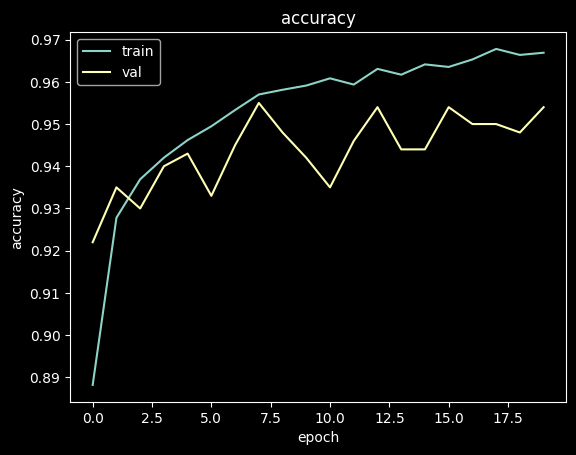

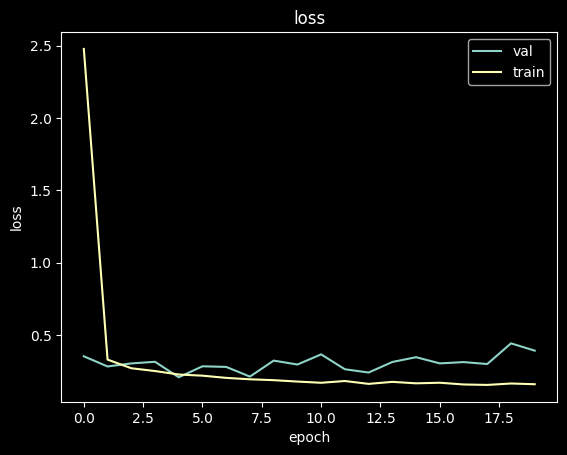

In [21]:
model.evaluate(x_test, y_test_onehot)
plot_history(history)

I still can't overfit the train to 100% and remain at 94% test so let's try making the neural network deeper before going to CNN.

In [22]:
def nn_v2():
  inputs = keras.Input(shape=(28,28))
  flat = keras.layers.Flatten()(inputs)

  h0 = keras.layers.Dense(256, activation="relu")(flat)
  h1 = keras.layers.Dense(256, activation="relu")(h0)

  outputs = keras.layers.Dense(10)(h1)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

model = nn_v2()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(x_train, y_train_onehot, epochs=20,
                    validation_data=(x_val, y_val_onehot))

Epoch 1/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8506 - loss: 4.3645 - val_accuracy: 0.9460 - val_loss: 0.3642
Epoch 2/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9433 - loss: 0.2871 - val_accuracy: 0.9420 - val_loss: 0.2348
Epoch 3/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9548 - loss: 0.1717 - val_accuracy: 0.9540 - val_loss: 0.2027
Epoch 4/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9571 - loss: 0.1667 - val_accuracy: 0.9690 - val_loss: 0.1432
Epoch 5/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9622 - loss: 0.1329 - val_accuracy: 0.9670 - val_loss: 0.1549
Epoch 6/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9671 - loss: 0.1162 - val_accuracy: 0.9590 - val_loss: 0.1519
Epoch 7/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9696 - loss: 0.1142 - val_accuracy: 0.9570 - val_loss: 0.1796
Epoch 8/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9724 - loss: 0.1030 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9660 - loss: 0.3183


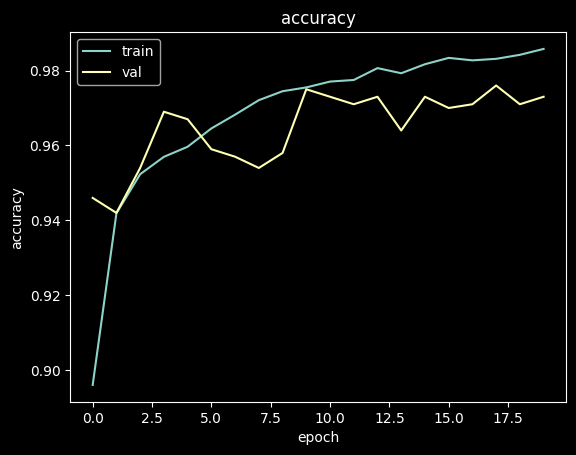

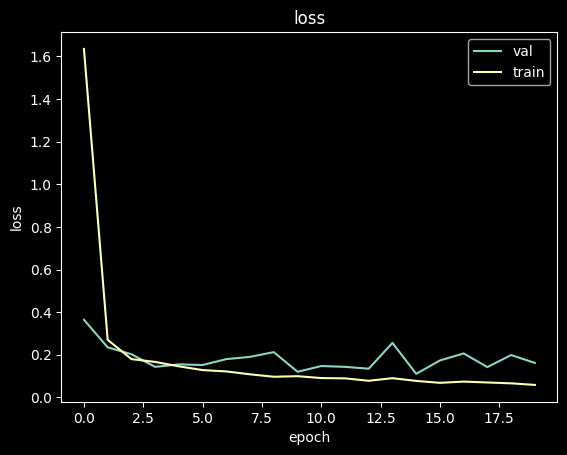

In [24]:
model.evaluate(x_test, y_test_onehot)
plot_history(history)

Maybe if we kept training we could have gotten further!, but there seemed to be plateua in training. So let's once again add another layer and see if we get better perf!

In [26]:
def nn_v3():
  inputs = keras.Input(shape=(28,28))
  flat = keras.layers.Flatten()(inputs)

  h0 = keras.layers.Dense(256, activation="relu")(flat)
  h1 = keras.layers.Dense(256, activation="relu")(h0)
  h2 = keras.layers.Dense(256, activation="relu")(h1)

  outputs = keras.layers.Dense(10)(h2)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

model = nn_v3()
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 335,114 (1.28 MB)

 Trainable params: 335,114 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(x_train, y_train_onehot, epochs=20,
                    validation_data=(x_val, y_val_onehot))

Epoch 1/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8393 - loss: 2.7450 - val_accuracy: 0.9310 - val_loss: 0.2389
Epoch 2/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9474 - loss: 0.1888 - val_accuracy: 0.9500 - val_loss: 0.2057
Epoch 3/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9593 - loss: 0.1436 - val_accuracy: 0.9550 - val_loss: 0.1773
Epoch 4/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9620 - loss: 0.1341 - val_accuracy: 0.9530 - val_loss: 0.2030
Epoch 5/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9715 - loss: 0.1050 - val_accuracy: 0.9690 - val_loss: 0.1593
Epoch 6/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9694 - loss: 0.1118 - val_accuracy: 0.9690 - val_loss: 0.1416
Epoch 7/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9758 - loss: 0.0917 - val_accuracy: 0.9670 - val_loss: 0.1234
Epoch 8/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9789 - loss: 0.0790 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9637 - loss: 0.2868


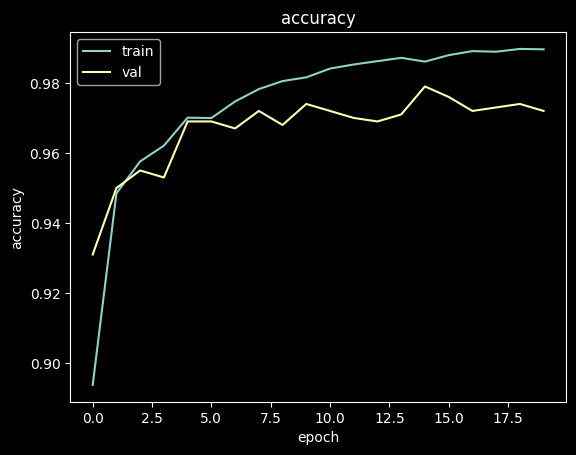

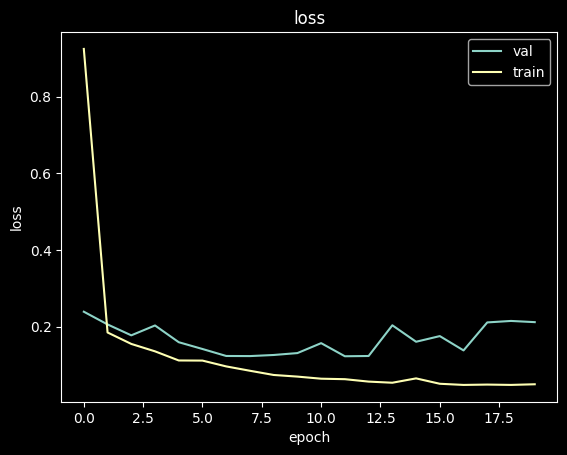

In [29]:
model.evaluate(x_test, y_test_onehot)
plot_history(history)

The validation accuracy has completely plataued for a model that completely overfits at 100%. So I could either find better hyperparams, or I could switch to an inductive bias that is more likely to work on unseen data rather than just learning global patterns in the train data.

Although, let's be clear! 96% is pretty darn good still!

Before I do the CNN, let's just quickly try out regularizing the loss by adding weight decay to make the model simpler and likely more general.

In [30]:
model.compile(optimizer=keras.optimizers.Adam(weight_decay=0.04), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(x_train, y_train_onehot, epochs=20,
                    validation_data=(x_val, y_val_onehot))

Epoch 1/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9889 - loss: 0.0591 - val_accuracy: 0.9720 - val_loss: 0.1557
Epoch 2/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9899 - loss: 0.0435 - val_accuracy: 0.9720 - val_loss: 0.2635
Epoch 3/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9886 - loss: 0.0526 - val_accuracy: 0.9810 - val_loss: 0.0730
Epoch 4/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9898 - loss: 0.0407 - val_accuracy: 0.9830 - val_loss: 0.0736
Epoch 5/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9893 - loss: 0.0472 - val_accuracy: 0.9770 - val_loss: 0.1144
Epoch 6/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9885 - loss: 0.0513 - val_accuracy: 0.9730 - val_loss: 0.0997
Epoch 7/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9917 - loss: 0.0366 - val_accuracy: 0.9800 - val_loss: 0.1107
Epoch 8/20
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9899 - loss: 0.0406 - 

In [31]:
model.evaluate(x_test, y_test_onehot)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9766 - loss: 0.1216


[0.10659078508615494, 0.9789000153541565]

## CNN

Okay the best I could do with a MLP is 97.66% accuracy on the validation set for a three hidden layer network with 256 neurons each with a small weight decay.

Let's see what we can get with a simple CNN.